In [ ]:
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━ 8.4/10.8 MB 1.8 MB/s eta 0:00:02

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
# For undersamping
from imblearn.under_sampling import RandomUnderSampler

# for encoding and normalization
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler


In [32]:
df = pd.read_csv(r"/accepted_2007_to_2018Q4.csv")
df.shape

<ipython-input-32-41e121497fd2>:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"/accepted_2007_to_2018Q4.csv")


(2260701, 151)

In [33]:
pd.set_option('display.max_columns', None)

In [34]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [35]:
df.loan_status.value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

In [36]:
# Add necessary variables
# Determining the loans that are bad from loan_status column --dependent variable (y)
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period",
            "Late (16-30 days)", "Late (31-120 days)"]
df['loan_condition_int'] = df['loan_status'].apply(lambda status: 1 if status in bad_loan else 0).astype(int)
df['loan_condition'] = np.where(df['loan_condition_int'] == 0, 'Good Loan', 'Bad Loan')

#emp_length
emp_length_mapping = {
    '10+ years': 10,
    '9 years': 9,
    '8 years': 8,
    '7 years': 7,
    '6 years': 6,
    '5 years': 5,
    '4 years': 4,
    '3 years': 3,
    '2 years': 2,
    '1 year': 1,
    '< 1 year': 0.5,
    'n/a': 0
}
df['emp_length_int'] =df['emp_length'].map(emp_length_mapping)
df.head().transpose()

# region
state_to_region = {
    'CA': 'West', 'OR': 'West', 'UT': 'West', 'WA': 'West', 'CO': 'West',
    'NV': 'West', 'AK': 'West', 'MT': 'West', 'HI': 'West', 'WY': 'West', 'ID': 'West',
    'AZ': 'SouthWest', 'TX': 'SouthWest', 'NM': 'SouthWest', 'OK': 'SouthWest',
    'GA': 'SouthEast', 'NC': 'SouthEast', 'VA': 'SouthEast', 'FL': 'SouthEast', 'KY': 'SouthEast',
    'SC': 'SouthEast', 'LA': 'SouthEast', 'AL': 'SouthEast', 'WV': 'SouthEast', 'DC': 'SouthEast',
    'AR': 'SouthEast', 'DE': 'SouthEast', 'MS': 'SouthEast', 'TN': 'SouthEast',
    'IL': 'MidWest', 'MO': 'MidWest', 'MN': 'MidWest', 'OH': 'MidWest', 'WI': 'MidWest',
    'KS': 'MidWest', 'MI': 'MidWest', 'SD': 'MidWest', 'IA': 'MidWest', 'NE': 'MidWest',
    'IN': 'MidWest', 'ND': 'MidWest',
    'CT': 'NorthEast', 'NY': 'NorthEast', 'PA': 'NorthEast', 'NJ': 'NorthEast', 'RI': 'NorthEast',
    'MA': 'NorthEast', 'MD': 'NorthEast', 'VT': 'NorthEast', 'NH': 'NorthEast', 'ME': 'NorthEast'
}
df['region'] = df['addr_state'].map(state_to_region)

In [37]:
df['loan_condition'].value_counts(normalize=True)

loan_condition
Good Loan    0.8657
Bad Loan     0.1343
Name: proportion, dtype: float64

In [39]:
df.groupby('issue_d')['loan_condition'].value_counts()

issue_d   loan_condition
Apr-2008  Good Loan           196
          Bad Loan             63
Apr-2009  Good Loan           284
          Bad Loan             49
Apr-2010  Good Loan           811
                            ...  
Sep-2016  Bad Loan           4719
Sep-2017  Good Loan         35084
          Bad Loan           4629
Sep-2018  Good Loan         38056
          Bad Loan            970
Name: count, Length: 278, dtype: int64

In [40]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

# Convert datetime to the desired format
df['issue_d'] = df['issue_d'].dt.strftime('%Y%m')

In [41]:
df['issue_d'] = df['issue_d'].fillna(0).astype(float).astype(int)

In [42]:
#maintaining the proportion of good and bad loans - taking only data points  2012 onwards
thresh_dt = 201112
filtered_df = df[df['issue_d']>thresh_dt]
filtered_df['loan_condition'].value_counts(normalize=True)

loan_condition
Good Loan    0.866022
Bad Loan     0.133978
Name: proportion, dtype: float64

In [43]:
filtered_df.shape

(2218133, 155)

In [44]:
df = filtered_df

In [45]:
nul = df.isnull().mean().sort_values()

In [46]:
nul

chargeoff_within_12_mths                      0.000000
collection_recovery_fee                       0.000000
last_pymnt_amnt                               0.000000
last_fico_range_high                          0.000000
last_fico_range_low                           0.000000
                                                ...   
hardship_payoff_balance_amount                0.995078
hardship_last_payment_amount                  0.995078
hardship_amount                               0.995078
orig_projected_additional_accrued_interest    0.996100
member_id                                     1.000000
Length: 155, dtype: float64

In [47]:
#removing columns where null values are more than 50%, we already have a lot of features to play around with
nul = nul[nul>0.5]

In [48]:
nul

mths_since_last_delinq                        0.510148
next_pymnt_d                                  0.588569
mths_since_recent_revol_delinq                0.666224
mths_since_last_major_derog                   0.738169
mths_since_recent_bc_dlq                      0.765703
mths_since_last_record                        0.839728
annual_inc_joint                              0.945580
dti_joint                                     0.945582
verification_status_joint                     0.947825
sec_app_fico_range_high                       0.951301
sec_app_collections_12_mths_ex_med            0.951301
sec_app_open_act_il                           0.951301
sec_app_num_rev_accts                         0.951301
sec_app_chargeoff_within_12_mths              0.951301
sec_app_open_acc                              0.951301
sec_app_inq_last_6mths                        0.951301
sec_app_earliest_cr_line                      0.951301
sec_app_mort_acc                              0.951301
sec_app_fi

In [49]:
nul_col = nul.sort_values(ascending = False).index

In [50]:
df = df.drop(nul_col, axis = 1)

In [51]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,loan_condition_int,loan_condition,emp_length_int,region
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,201512,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N,0,Good Loan,10.0,NorthEast
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,201512,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N,0,Good Loan,10.0,MidWest
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,201512,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N,0,Good Loan,10.0,MidWest
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,201512,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12

In [52]:
df.shape

(2218133, 111)

In [53]:
df.isna().sum()

id                           0
loan_amnt                    0
funded_amnt                  0
funded_amnt_inv              0
term                         0
                         ...  
debt_settlement_flag         0
loan_condition_int           0
loan_condition               0
emp_length_int          145795
region                       0
Length: 111, dtype: int64

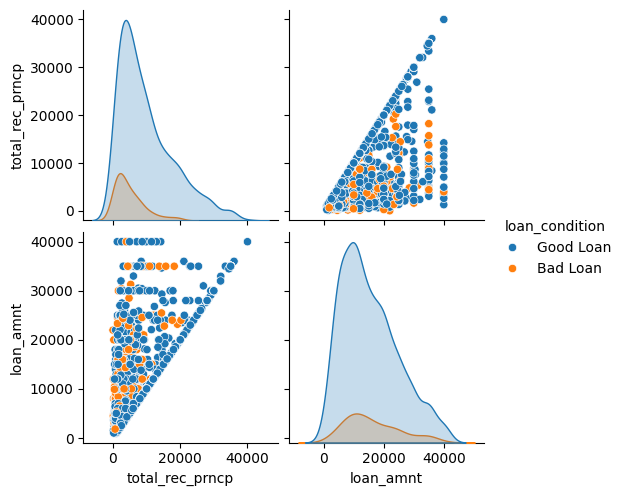

In [54]:
#Delete dynamic indicators In fact, certain variables directly indicate the outcome of the loan condition, such as the total_rec_prnp (Principal received to date) shown in the chart. If this value is equal to the loan_amnt (loan amount), it directly signifies that the loan is a good loan. In other words, since we assume that we are within the loan repayment period for prediction purposes, we should eliminate variables that change before and after the loan term, and ensure that only variables directly influencing the loan condition outcome are preserved.
sns.pairplot(df[['total_rec_prncp', 'loan_condition', 'loan_amnt']].sample(n=1000, random_state=42), hue='loan_condition')

In [55]:
##similarly for other direct indicators
direct_indicators = [
    'collection_recovery_fee',
    'last_pymnt_amnt',
    'out_prncp',
    'out_prncp_inv',
    'recoveries',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp'
]

drop_df = df.drop(direct_indicators, axis=1)

In [56]:
drop_df.shape

(2218133, 101)

In [57]:
#drop repeated features
# drop_df.drop(['loan_condition'], axis=1, inplace=True)
# drop_df.drop(['loan_status'], axis=1, inplace=True)
drop_df.drop(['emp_length'], axis=1, inplace=True)

drop_df.drop(['id','emp_title','url','title','zip_code'], axis=1, inplace=True)

In [58]:
drop_df.shape

(2218133, 95)

missing values immputation


In [59]:
fillna_df = drop_df.copy()

# for object variables - Get the mode of next payment date and last payment date and the last date credit amount was pulled
for column in ["last_pymnt_d", "last_credit_pull_d"]:  #, 'income_category'
    fillna_df[column] = fillna_df.groupby("region")[column].transform(lambda x: x.fillna(x.mode()))

# for numerical variables
# Get the mode on the number of accounts in which the client is delinquent
fillna_df["pub_rec"] = fillna_df.groupby("region")["pub_rec"].transform(lambda x: x.fillna(x.median()))
# Get the mode of the total number of credit lines the borrower has
fillna_df["total_acc"] = fillna_df.groupby("region")["total_acc"].transform(lambda x: x.fillna(x.median()))

fillna_df["emp_length_int"] = fillna_df.groupby("region")["emp_length_int"].transform(lambda x: x.fillna(x.median()))

# Get the mean of the annual income depending on the region the client is located.
fillna_df["annual_inc"] = fillna_df.groupby("region")["annual_inc"].transform(lambda x: x.fillna(x.mean()))
# Mode of credit delinquencies in the past two years.
fillna_df["delinq_2yrs"] = fillna_df.groupby("region")["delinq_2yrs"].transform(lambda x: x.fillna(x.mean()))

In [60]:
# for other, fill in with zero
fillna_df.fillna(0, inplace=True)
fillna_df.isna().sum().reset_index()

,index,0
0,loan_amnt,0
1,funded_amnt,0
2,funded_amnt_inv,0
3,term,0
4,int_rate,0
...,...,...
90,debt_settlement_flag,0
91,loan_condition_int,0
92,loan_condition,0
93,emp_length_int,0


removing outliers

In [61]:
def remove_outliers(df, columns):
    for col in columns:
        # Calculate the 90th percentile
        percentile_90 = df[col].quantile(0.9)
        # Drop values above the 90th percentile
        df = df[df[col] <= percentile_90]
    return df

In [62]:
RemoveOutlier_df = df.copy()
print("Dataset before removing outlier:",RemoveOutlier_df.shape)
RemoveOutlier_df = remove_outliers(RemoveOutlier_df,['annual_inc','dti','open_acc','total_acc','revol_util','revol_bal'])
print("Dataset before removing outlier:",RemoveOutlier_df.shape)

Dataset before removing outlier: (2218133, 111)
Dataset before removing outlier: (1206649, 111)


In [63]:
df = RemoveOutlier_df

In [64]:
df.shape

(1206649, 111)

In [65]:
RemoveOutlier_df.loan_condition.value_counts(normalize = True)

loan_condition
Good Loan    0.869123
Bad Loan     0.130877
Name: proportion, dtype: float64

correlation

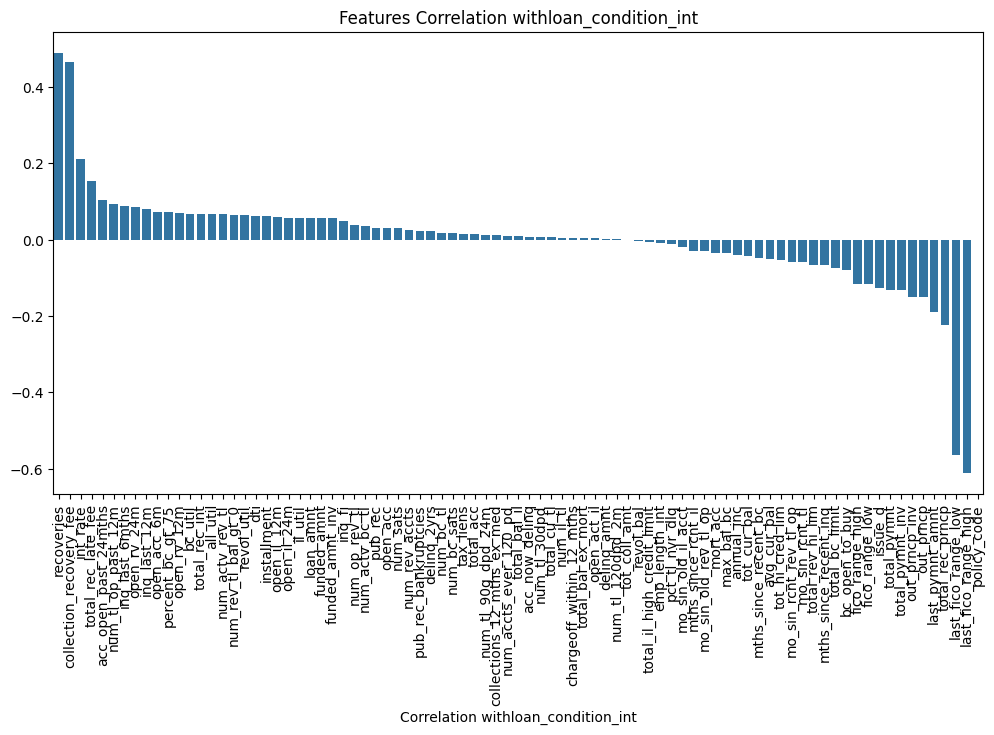

recoveries                 0.489079
collection_recovery_fee    0.466315
int_rate                   0.212148
total_rec_late_fee         0.154600
acc_open_past_24mths       0.103901
                             ...   
last_pymnt_amnt           -0.188207
total_rec_prncp           -0.222476
last_fico_range_low       -0.563744
last_fico_range_high      -0.610975
policy_code                     NaN
Name: loan_condition_int, Length: 85, dtype: float64


In [66]:
target_col = target_variable = "loan_condition_int"
corr_df = df.copy()

# correlation with y
correlation_with_loan_condition = corr_df.select_dtypes(include=['int64', 'float64']).corr()[target_variable]
sorted_correlation = correlation_with_loan_condition.drop(target_variable).sort_values(ascending=False)

# plot
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_correlation.index, y=sorted_correlation.values, orient='v')
plt.xlabel('Correlation with{}'.format(target_variable))
plt.title('Features Correlation with{}'.format(target_variable))
plt.xticks(rotation=90)
plt.show()
print(sorted_correlation)

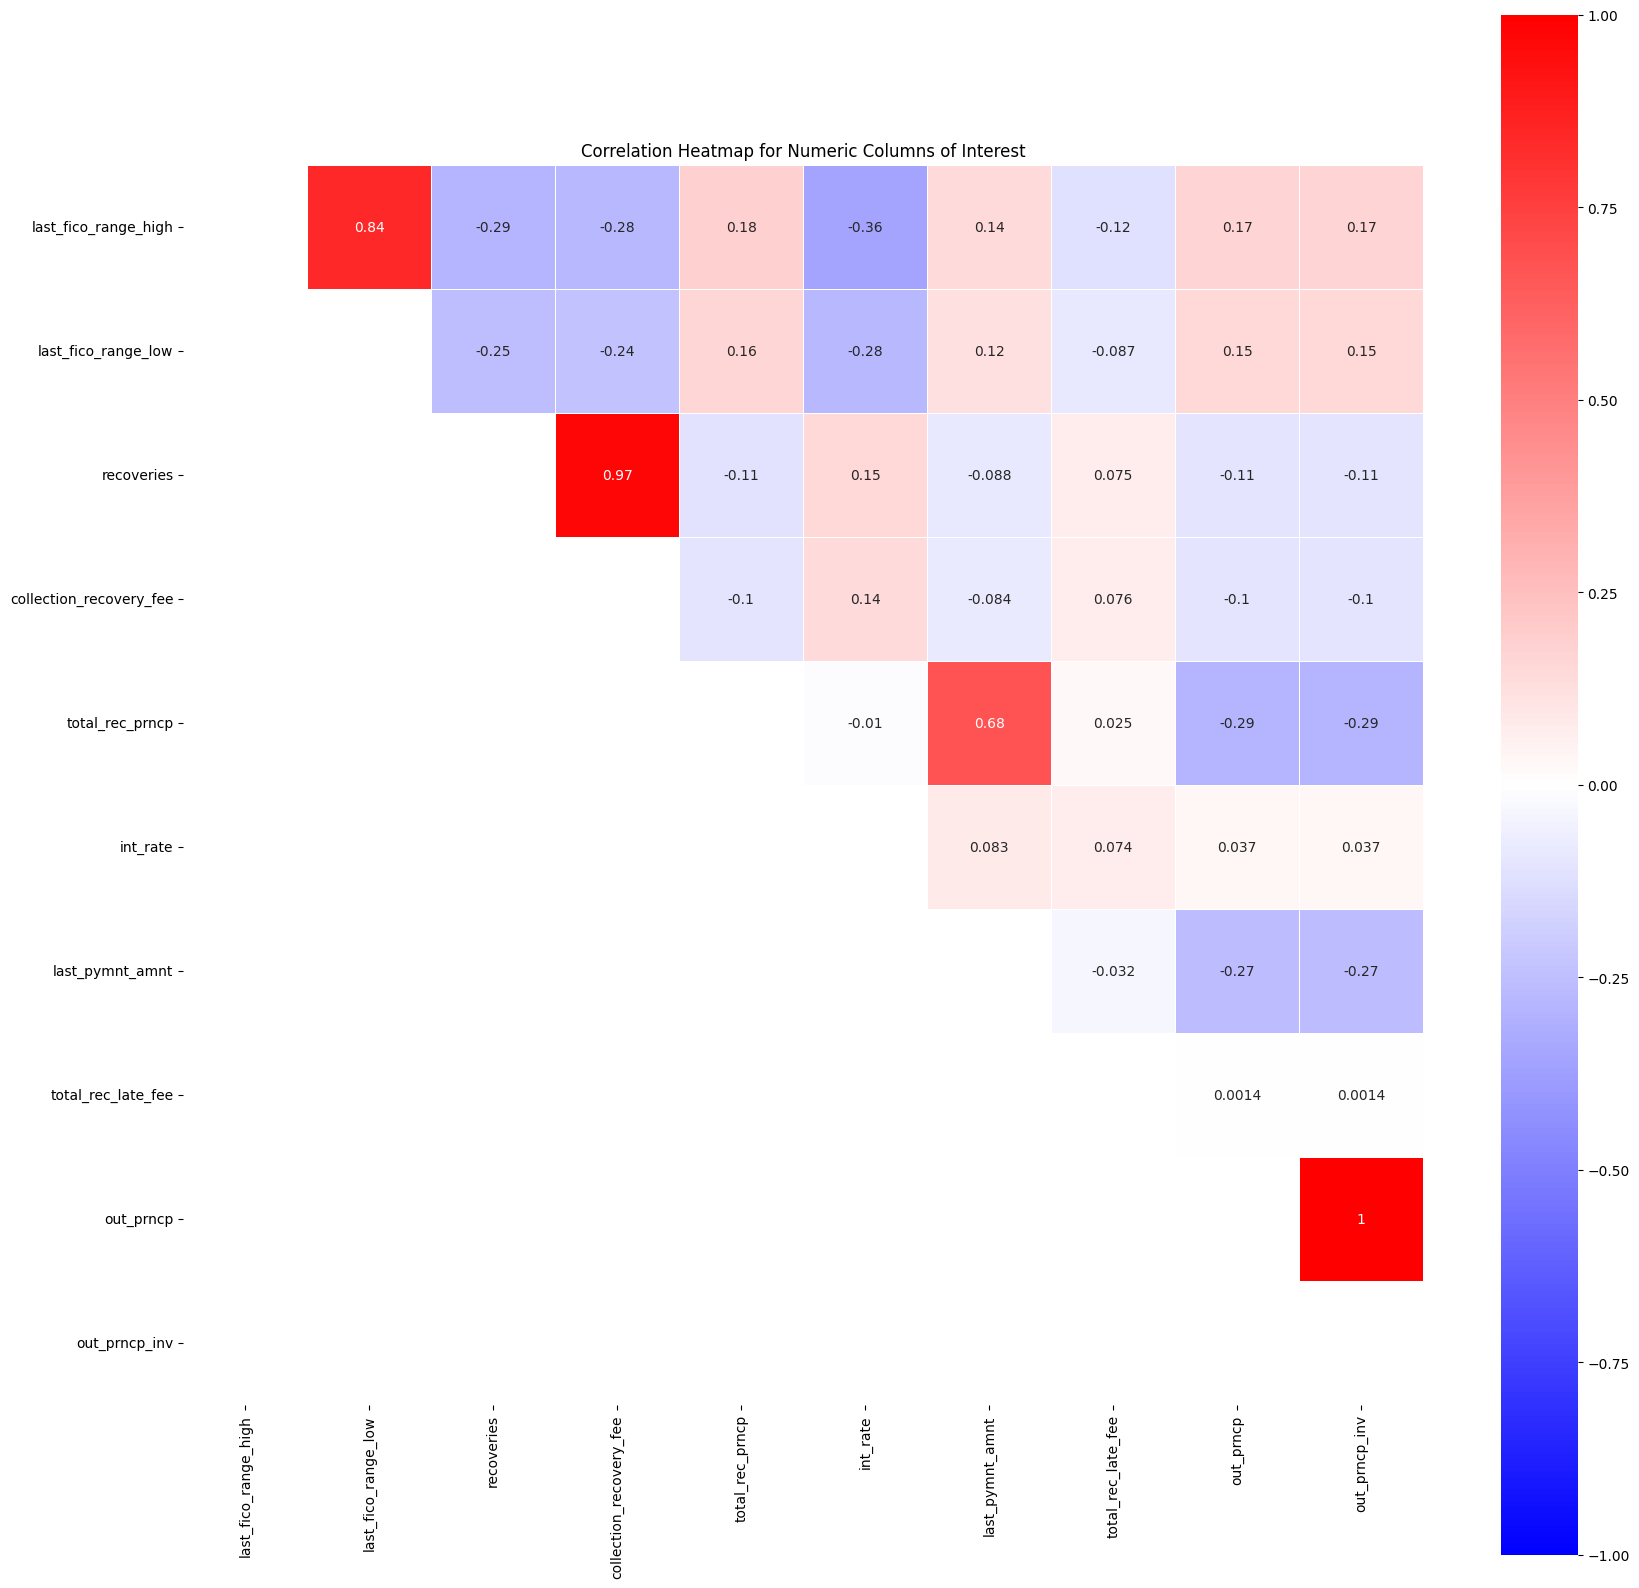

In [67]:
top_variables = sorted_correlation.abs().nlargest(10).index.tolist()

plt.figure(figsize=(20, 20))
correlation_matrix = df[top_variables].corr()
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, cmap='bwr', vmin=-1, vmax=1, square=True, linewidths=0.5, mask=mask)
plt.title('Correlation Heatmap for Numeric Columns of Interest')
plt.show()

target encoding for multicat , onehot encoding for binary cat and normalization for numerical

In [68]:
TE_df = df.copy()
# divide variables into numerical variables and categorical variables, categorical variables are divided into binary variables and multivariate variables
original_cols = TE_df.columns

cat_cols = [col for col in TE_df.select_dtypes(include=['object']).columns.tolist() if col not in ['id','loan_status','loan_condition']]
num_cols = [col for col in TE_df.select_dtypes(exclude=['object']).columns.tolist() if col not in ['id', 'loan_condition_int']]

dual_cat_cols = [col for col in cat_cols if TE_df[col].nunique()<=2]
multi_cat_cols =[col for col in cat_cols if TE_df[col].nunique()>2]

multi_cat_cols

['grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'last_pymnt_d',
 'last_credit_pull_d',
 'region']

In [69]:
dual_cat_cols

['term',
 'pymnt_plan',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

In [70]:
# binary encoding for dual_cat_cols
#dual_cat_cols
TE_df = pd.get_dummies(TE_df, columns=dual_cat_cols, drop_first=True)
TE_df.shape
# update dual_cat_cols
changed_columns = [col for col in TE_df.columns if col not in original_cols]
dual_cat_cols = changed_columns

TE_df.head().transpose()

,0,2,3,4,5
id,68407277,68341763,66310712,68476807,68426831
loan_amnt,3600.0,20000.0,35000.0,10400.0,11950.0
funded_amnt,3600.0,20000.0,35000.0,10400.0,11950.0
funded_amnt_inv,3600.0,20000.0,35000.0,10400.0,11950.0
int_rate,13.99,10.78,14.85,22.45,13.44
...,...,...,...,...,...
initial_list_status_w,True,True,True,True,True
application_type_Joint App,False,True,False,False,False
hardship_flag_Y,False,False,False,False,False
disbursement_method_DirectPay,False,False,False,False,False


In [71]:
TE_df.columns.tolist()

['id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'a

In [72]:
TE_df.drop(['loan_condition','loan_status'], axis = 1, inplace = True)

In [73]:
from sklearn.model_selection import train_test_split
# Assuming X contains your features and y contains your target variable
X = TE_df.drop(['loan_condition_int'], axis = 1)
y = TE_df['loan_condition_int']

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [74]:
pd.DataFrame(y_test)['loan_condition_int'].value_counts(normalize = True)

loan_condition_int
0    0.869125
1    0.130875
Name: proportion, dtype: float64

In [75]:
pd.DataFrame(y_train).shape

(965319, 1)

In [76]:
train_X = pd.DataFrame(X_train)
test_X = pd.DataFrame(X_test)
train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)


In [77]:
#handling multicat for training and testing
# Create a data set containing only multi-categorical variables
multi_cat_train_X = train_X[multi_cat_cols]
multi_cat_test_X = test_X[multi_cat_cols]

# Target encode categorical variables with smoothing method (on train set)
encoder = TargetEncoder(smoothing=0.2)
encoder.fit(multi_cat_train_X, train_y)

# Apply the same encoding rules on train and test set
encoded_multi_cat_train_X = encoder.transform(multi_cat_train_X)
encoded_multi_cat_test_X = encoder.transform(multi_cat_test_X)

encoded_train_X = pd.concat([train_X.drop(columns=multi_cat_cols), encoded_multi_cat_train_X], axis=1)
encoded_test_X = pd.concat([test_X.drop(columns=multi_cat_cols), encoded_multi_cat_test_X], axis=1)

encoded_train_X.head().transpose()

,1857759,252716,129031,801536,302492
id,4315056,51848146,60873530,138788881,46633674
loan_amnt,14575.0,10000.0,3600.0,10500.0,8300.0
funded_amnt,14575.0,10000.0,3600.0,10500.0,8300.0
funded_amnt_inv,14575.0,9750.0,3600.0,10500.0,8200.0
int_rate,14.33,19.19,13.99,14.47,9.99
...,...,...,...,...,...
addr_state,0.151532,0.108596,0.123791,0.139964,0.139964
earliest_cr_line,0.121279,0.133853,0.11622,0.133853,0.126852
last_pymnt_d,0.221399,0.008943,0.194971,0.008943,0.18521
last_credit_pull_d,0.140362,0.070324,0.070324,0.070324,0.277893


In [78]:
#normalizing numerical
scaler = StandardScaler()

# Fit and apply normalization on the training set
standardized_train_X = encoded_train_X.copy()
standardized_train_X[num_cols] = scaler.fit_transform(encoded_train_X[num_cols])

# Apply the same normalization rules on the test set
standardized_test_X = encoded_test_X.copy()
standardized_test_X[num_cols] = scaler.transform(encoded_test_X[num_cols])

standardized_train_X.head().transpose()

,1857759,252716,129031,801536,302492
id,4315056,51848146,60873530,138788881,46633674
loan_amnt,0.237134,-0.353979,-1.180892,-0.289377,-0.573628
funded_amnt,0.237158,-0.353965,-1.180891,-0.289361,-0.573617
funded_amnt_inv,0.237838,-0.385739,-1.180558,-0.28881,-0.586059
int_rate,0.308581,1.339714,0.236444,0.338285,-0.612225
...,...,...,...,...,...
addr_state,0.151532,0.108596,0.123791,0.139964,0.139964
earliest_cr_line,0.121279,0.133853,0.11622,0.133853,0.126852
last_pymnt_d,0.221399,0.008943,0.194971,0.008943,0.18521
last_credit_pull_d,0.140362,0.070324,0.070324,0.070324,0.277893


In [79]:
standardized_train_X = standardized_train_X.fillna(0).drop('id', axis = 1)
standardized_test_X = standardized_test_X.fillna(0).drop('id', axis = 1)

In [80]:
print(standardized_train_X.shape)
print(standardized_train_X.info())
print(train_y.shape)
print(train_y['loan_condition_int'].value_counts(normalize = True))
print(standardized_test_X.shape)
print(test_y.shape)
print(test_y['loan_condition_int'].value_counts(normalize = True))

(965319, 107)
<class 'pandas.core.frame.DataFrame'>
Index: 965319 entries, 1857759 to 1933141
Columns: 107 entries, loan_amnt to region
dtypes: bool(7), float64(100)
memory usage: 750.3 MB
None
(965319, 1)
loan_condition_int
0    0.869123
1    0.130877
Name: proportion, dtype: float64
(241330, 107)
(241330, 1)
loan_condition_int
0    0.869125
1    0.130875
Name: proportion, dtype: float64


In [81]:
standardized_train_X.select_dtypes(include=['object']).columns.tolist()

[]

In [82]:
standardized_test_X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,issue_d,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,emp_length_int,term_ 60 months,pymnt_plan_y,initial_list_status_w,application_type_Joint App,hardship_flag_Y,disbursement_method_DirectPay,debt_settlement_flag_Y,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,url,purpose,title,zip_code,addr_state,earliest_cr_line,last_pymnt_d,last_credit_pull_d,region
511328,0.679662,0.679692,0.680481,-1.441799,0.746194,0.881431,1.190687,-1.383119,2.164488,-1.138958,-1.138930,0.556979,-0.996258,-0.384649,1.390230,1.725260,-0.670629,1.239777,1.240084,-0.297822,-0.297432,-0.202846,-0.417401,-0.129893,-0.189659,-0.180598,-0.461650,0.695777,0.521832,-0.13045,0.0,-0.05599,-0.023798,-0.716700,-0.823817,-1.040711,-0.705678,-0.983711,0.907886,-0.840296,0.000000,-0.905857,-1.164942,0.947624,1.393424,-0.120296,-0.663449,-0.552695,-0.399577,-1.546823,-0.588308,-0.698740,1.512018,-0.08031,-0.017002,0.466233,-0.270409,1.639756,3.495177,0.521235,0.659816,-1.028627,-0.401105,0.517100,0.119476,-0.000649,-0.679552,-0.263708,-0.296254,-0.809854,0.135719,-0.990101,-0.022766,-0.046474,-0.180663,-1.184154,-1.531267,1.823804,-0.390300,-0.129127,-0.827233,-0.538654,-0.093552,-1.037424,1.170175,False,False,True,False,False,True,False,0.037312,0.028333,0.103347,0.121725,0.129809,0.139874,0.130877,0.104926,0.102174,0.132810,0.138031,0.146445,0.008943,0.070324,0.135547
1763060,0.679662,0.679692,0.680481,1.203927,1.227341,2.016209,-1.790054,-1.421406,-0.359346,-0.992395,-0.992371,2.960297,0.124476,6.248979,-0.367740,1.632565,1.709832,-0.572126,-0.572063,1.646404,1.647624,1.444553,1.646814,-0.129893,-0.189659,-0.180598,-0.440648,0.359738,0.309400,-0.13045,0.0,-0.05599,-0.023798,0.803507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.884011,0.000000,0.000000,0.000000,1.087484,0.547597,-0.612035,0.958171,-0.08031,-0.017002,0.447802,2.086790,0.037762,-0.593736,1.150438,-0.326915,-1.028627,0.421337,1.648192,0.525642,1.364673,1.347873,1.393623,0.019523,0.838104,0.549206,0.131880,-0.022766,-0.046474,-0.180663,0.658299,-1.170300,1.004814,2.121093,7.716526,0.555824,-0.277747,-0.528197,-0.383533,-1.036574,False,False,False,False,False,False,False,0.214210,0.207267,0.130877,0.129283,0.113898,0.178662,0.130877,0.140625,0.171429,0.129994,0.149814,0.109756,0.232018,0.070324,0.130270
1762719,-1.000005,-1.000001,-0.999624,-0.187890,-0.964770,-1.135812,-1.790054,1.287356,-0.359346,-0.406141,-0.406136,1.758638,0.684843,-0.384649,0.454722,-0.124014,1.048593,-0.572126,-0.572063,-0.504210,-0.503909,-0.436331,-0.452768,-0.129893,-0.189659,-0.180598,-0.536683,-1.858115,-1.092655,-0.13045,0.0,-0.05599,-0.023798,0.720423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.312677,0.000000,0.000000,0.000000,0.711154,0.267234,-0.052

In [83]:
#replacing False with 0 and True with 1 across the train and test X dfs
standardized_train_X = standardized_train_X.replace({True: 1, False: 0})
standardized_test_X = standardized_test_X.replace({True: 1, False: 0})

In [84]:
standardized_test_X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,issue_d,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,emp_length_int,term_ 60 months,pymnt_plan_y,initial_list_status_w,application_type_Joint App,hardship_flag_Y,disbursement_method_DirectPay,debt_settlement_flag_Y,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,url,purpose,title,zip_code,addr_state,earliest_cr_line,last_pymnt_d,last_credit_pull_d,region
511328,0.679662,0.679692,0.680481,-1.441799,0.746194,0.881431,1.190687,-1.383119,2.164488,-1.138958,-1.138930,0.556979,-0.996258,-0.384649,1.390230,1.725260,-0.670629,1.239777,1.240084,-0.297822,-0.297432,-0.202846,-0.417401,-0.129893,-0.189659,-0.180598,-0.461650,0.695777,0.521832,-0.13045,0.0,-0.05599,-0.023798,-0.716700,-0.823817,-1.040711,-0.705678,-0.983711,0.907886,-0.840296,0.000000,-0.905857,-1.164942,0.947624,1.393424,-0.120296,-0.663449,-0.552695,-0.399577,-1.546823,-0.588308,-0.698740,1.512018,-0.08031,-0.017002,0.466233,-0.270409,1.639756,3.495177,0.521235,0.659816,-1.028627,-0.401105,0.517100,0.119476,-0.000649,-0.679552,-0.263708,-0.296254,-0.809854,0.135719,-0.990101,-0.022766,-0.046474,-0.180663,-1.184154,-1.531267,1.823804,-0.390300,-0.129127,-0.827233,-0.538654,-0.093552,-1.037424,1.170175,0,0,1,0,0,1,0,0.037312,0.028333,0.103347,0.121725,0.129809,0.139874,0.130877,0.104926,0.102174,0.132810,0.138031,0.146445,0.008943,0.070324,0.135547
1763060,0.679662,0.679692,0.680481,1.203927,1.227341,2.016209,-1.790054,-1.421406,-0.359346,-0.992395,-0.992371,2.960297,0.124476,6.248979,-0.367740,1.632565,1.709832,-0.572126,-0.572063,1.646404,1.647624,1.444553,1.646814,-0.129893,-0.189659,-0.180598,-0.440648,0.359738,0.309400,-0.13045,0.0,-0.05599,-0.023798,0.803507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.884011,0.000000,0.000000,0.000000,1.087484,0.547597,-0.612035,0.958171,-0.08031,-0.017002,0.447802,2.086790,0.037762,-0.593736,1.150438,-0.326915,-1.028627,0.421337,1.648192,0.525642,1.364673,1.347873,1.393623,0.019523,0.838104,0.549206,0.131880,-0.022766,-0.046474,-0.180663,0.658299,-1.170300,1.004814,2.121093,7.716526,0.555824,-0.277747,-0.528197,-0.383533,-1.036574,0,0,0,0,0,0,0,0.214210,0.207267,0.130877,0.129283,0.113898,0.178662,0.130877,0.140625,0.171429,0.129994,0.149814,0.109756,0.232018,0.070324,0.130270
1762719,-1.000005,-1.000001,-0.999624,-0.187890,-0.964770,-1.135812,-1.790054,1.287356,-0.359346,-0.406141,-0.406136,1.758638,0.684843,-0.384649,0.454722,-0.124014,1.048593,-0.572126,-0.572063,-0.504210,-0.503909,-0.436331,-0.452768,-0.129893,-0.189659,-0.180598,-0.536683,-1.858115,-1.092655,-0.13045,0.0,-0.05599,-0.023798,0.720423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.312677,0.000000,0.000000,0.000000,0.711154,0.267234,-0.052928,-0.106366,-0.08031,-0.017002,0.650538,-0.120405,-0

In [85]:
standardized_train_X.to_csv('standardized_train_X.csv', index = False)
standardized_test_X.to_csv('standardized_test_X.csv', index = False)
train_y.to_csv('train_y.csv', index = False)
test_y.to_csv('test_y.csv', index = False)